In [260]:
from pathlib import Path
import json
import xgi
import numpy as np
import matplotlib.pyplot as plt

In [116]:

def read_jsonl(fname):
    out=[]
    with open(fname, 'r') as file:
        # Read each line in the file
        for line in file:
            # Parse the JSON string and add the resulting dictionary to the list
            out.append(json.loads(line))
    return out

def flatten(l):
    return [item for sublist in l for item in sublist]



In [593]:
dir_author = Path(".cache_author/")
fnames = list(dir_author.glob("*"))

target_PI = "A5035455593"
target_name = 'Laurent Hébert‐Dufresne'
PI_fnames = [fname for fname in fnames if fname.stem.split("_")[0] == target_PI]
PI_fnames = sorted(PI_fnames, key=lambda p: int(str(p).split('_')[-1].split('.')[0]))
print(f"PI's age: {len(PI_fnames)}")

PI's age: 14


In [692]:
def get_coauths_dict(fnames):
    all_coauths_aid = []
    all_coauths = []
    for fname in PI_fnames:
        all_auth_objects = flatten([_['authorships'] for _ in read_jsonl(fname)])
        all_coauths_aid += [_['author']['id'].split("/")[-1] for _ in all_auth_objects]
        all_coauths += [_['author']['display_name'] for _ in all_auth_objects]
    return {aid:n for aid,n in zip(all_coauths_aid, all_coauths)}

aid2name = get_coauths_dict(PI_fnames)

In [695]:
age_coauthors = []
for aid in aid2name.keys():
    age_coauthors.append({aid2name[aid]: len([fname for fname in fnames if fname.stem.split("_")[0] == aid])})

In [696]:
age_coauthors

[{'Vincent Marceau': 6},
 {'Pierre-André Noël': 15},
 {'Laurent Hébert‐Dufresne': 14},
 {'Antoine Allard': 19},
 {'Louis J. Dubé': 40},
 {'Jean-Gabriel Young': 12},
 {'Oscar Patterson-Lomba': 1},
 {'Georg M. Goerg': 1},
 {'Benjamin M. Althouse': 9},
 {'Samuel V. Scarpino': 6},
 {'Lauren Ancel Meyers': 4},
 {'John W. Ayers': 1},
 {'Marisa Bargsten': 1},
 {'Joan Baumbach': 1},
 {'John S. Brownstein': 1},
 {'Lauren Castro': 1},
 {'Hannah E. Clapham': 1},
 {'Derek A. T. Cummings': 1},
 {'Sara Y. Del Valle': 1},
 {'Stephen Eubank': 1},
 {'Geoffrey Fairchild': 1},
 {'Lyn Finelli': 1},
 {'Nicholas Generous': 1},
 {'Dylan B. George': 1},
 {'David R. Harper': 1},
 {'Michael A. Johansson': 1},
 {'Kevin J. Konty': 1},
 {'Marc Lipsitch': 3},
 {'Gabriel Milinovich': 1},
 {'Joseph D. Miller': 1},
 {'Elaine O. Nsoesie': 1},
 {'Donald R. Olson': 1},
 {'Michael J. Paul': 1},
 {'Philip M. Polgreen': 1},
 {'Reid Priedhorsky': 1},
 {'Jonathan M. Read': 1},
 {'Isabel Rodríguez-Barraquer': 1},
 {'Derek J. S

In [549]:
works = read_jsonl(PI_fnames[10]) 
print(f"# papers that year: {len(works)}")

# papers that year: 41


In [550]:
authors = works[0]['authorships']

In [551]:
def extract_coauthor(w, names=True):
    authors=w['authorships']
    if names:
        return [_['author']['display_name'] for _ in authors]
    else:
        return [coauth2idx[_['author']['display_name']] for _ in authors]

hyperedge_list = [extract_coauthor(w) for w in works]

In [407]:
def extract_coauthor_inst(works):
    time_collabo = {}  # Reset for each year
    for work in works:
        for a in work['authorships']:
            # a=work['authorships'][1]
            author_name = a['author']['display_name']

            institutions = a['institutions'] if 'institutions' in a else []
            
            # Increment collaboration count for the current year
            author_yearly_data = time_collabo.get(author_name, {'count': 0, 'institutions': {}})
            author_yearly_data['count'] += 1
            
            # Increment institution count for the current year
            for inst in institutions:
                inst_name = inst['display_name']
                author_yearly_data['institutions'][inst_name] = author_yearly_data['institutions'].get(inst_name, 0) + 1
            
            time_collabo[author_name] = author_yearly_data

    return time_collabo

In [540]:
time_collabo=extract_coauthor_inst(works)

In [409]:
def extract_main_inst(time_collabo, PI_name):
    # target_institutions = time_collabo['Louis J. Dubé']
    target_institution = max(time_collabo[PI_name]['institutions'], key=time_collabo[PI_name]['institutions'].get)
    out={}
    for author_name, author_data in time_collabo.items():
        shared_inst = None
        max_institution = None
        if author_data['institutions'] and target_institution:
            max_institution = max(author_data['institutions'], key=author_data['institutions'].get)
            if max_institution == target_institution:
                shared_inst = max_institution
        out.update({author_name: {'institution': max_institution, 'is_shared': True if shared_inst else False}})
    return out

node_meta_dict = extract_main_inst(time_collabo, target_name)

In [472]:
hyperedge_list_meta = []
for e in hyperedge_list:
    hyperedge_list_meta.append((e, {'local_work':True if sum([node_meta_dict[a]['is_shared'] for a in e]) > 1 else False}))

In [500]:
set_individuals_involved_local_work = set(flatten([_[0] for _ in hyperedge_list_meta if _[1]['local_work']]))

In [503]:
nodelist = []
for i,auth in enumerate(node_meta_dict.keys()):
    nodelist.append((auth, {
        'institution': node_meta_dict[auth]['institution'], 
        'is_shared': node_meta_dict[auth]['is_shared'],
        'involve_local_work': True if auth in set_individuals_involved_local_work  else False
        }))

In [504]:
H = xgi.Hypergraph()

In [505]:
H.add_nodes_from(nodelist)
H.add_edges_from(hyperedge_list_meta)
print(f"The hypergraph has {H.num_nodes} nodes and {H.num_edges} edges")

The hypergraph has 84 nodes and 41 edges


Highest degree: Laurent Hébert‐Dufresne


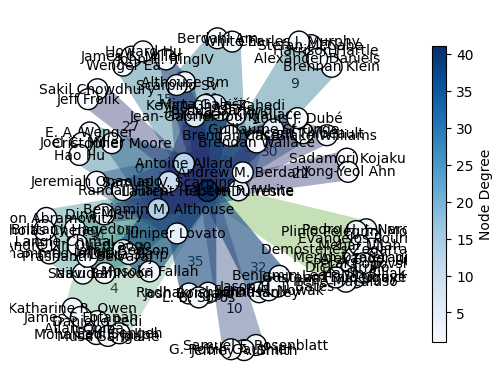

In [506]:
pos = xgi.barycenter_spring_layout(H, seed=42)  # fix position
ax, collections = xgi.draw(H, pos=pos, node_labels=True, node_size=15, node_fc=H.nodes.degree(), node_fc_cmap="Blues", hyperedge_labels=True, hull=True)
(node_collection, _, _) = collections
# print({H.nodes.degree().asdict()})

max_key = max(H.nodes.degree().asdict(), key=H.nodes.degree().asdict().get)
print(f"Highest degree: {max_key}") # highest degree node 
plt.colorbar(node_collection, label="Node Degree", shrink=0.8)

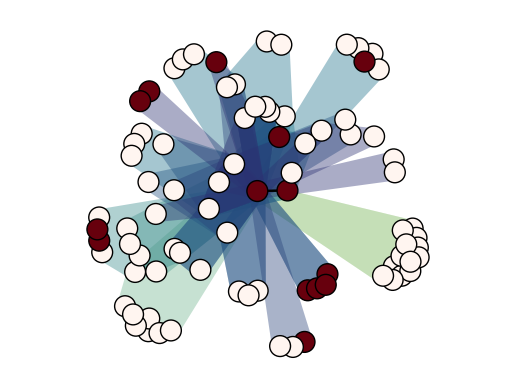

In [507]:
pos = xgi.barycenter_spring_layout(H, seed=42)  # fix position
ax, collections = xgi.draw(
    H, pos=pos, node_size=15, 
    node_fc=H.nodes.attrs("is_shared").aslist(), 
    hull=True)
(node_collection, _, _) = collections

max_key = max(H.nodes.degree().asdict(), key=H.nodes.degree().asdict().get)

In [515]:
H_f = xgi.subhypergraph(
    H, 
    nodes=H.nodes.filterby_attr("involve_local_work", True),
    edges=H.edges.filterby_attr("local_work", True)
)

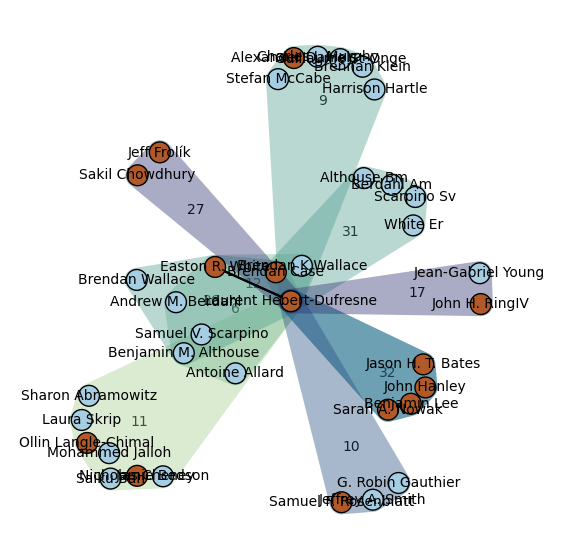

In [539]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
pos = xgi.barycenter_spring_layout(H_f, seed=42)  # fix position
ax, collections = xgi.draw(
    H_f, pos=pos, node_size=15, hyperedge_labels=True,
    node_fc=H_f.nodes.attrs("is_shared").aslist(), 
    node_fc_cmap="Paired", 
    node_labels=True,
    hull=True
    )
(node_collection, _, _) = collections

max_key = max(H_f.nodes.degree().asdict(), key=H.nodes.degree().asdict().get)
plt.savefig("test.png")

/Users/jstonge1/miniconda3/envs/cc/lib/python3.9/site-packages/xgi/drawing/draw.py:1487: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


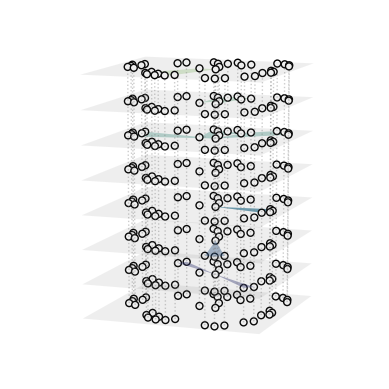

In [532]:
ax3 = plt.axes(projection="3d")  # requires a 3d axis
xgi.draw_multilayer(H_f, ax=ax3)

plt.show()

(<Axes: >,
 (<matplotlib.collections.PathCollection at 0x2b35fa460>,
  <matplotlib.collections.PatchCollection at 0x2b3556fa0>))

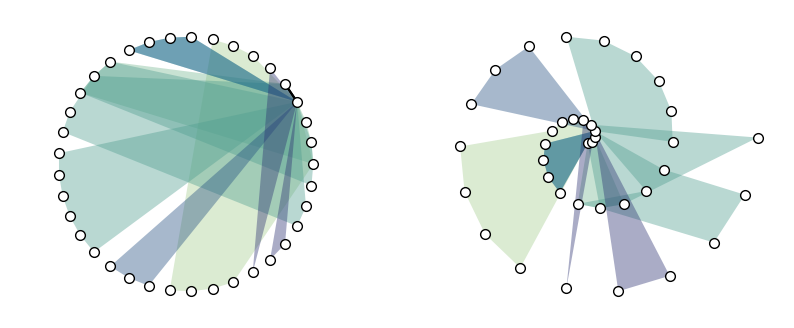

In [537]:
plt.figure(figsize=(10, 4))

ax = plt.subplot(1, 2, 1)
pos_circular = xgi.circular_layout(H_f)
xgi.draw(H_f, pos=pos_circular, ax=ax,)

ax = plt.subplot(1, 2, 2)
pos_spiral = xgi.spiral_layout(H_f)
xgi.draw(H_f, pos=pos_spiral, ax=ax)

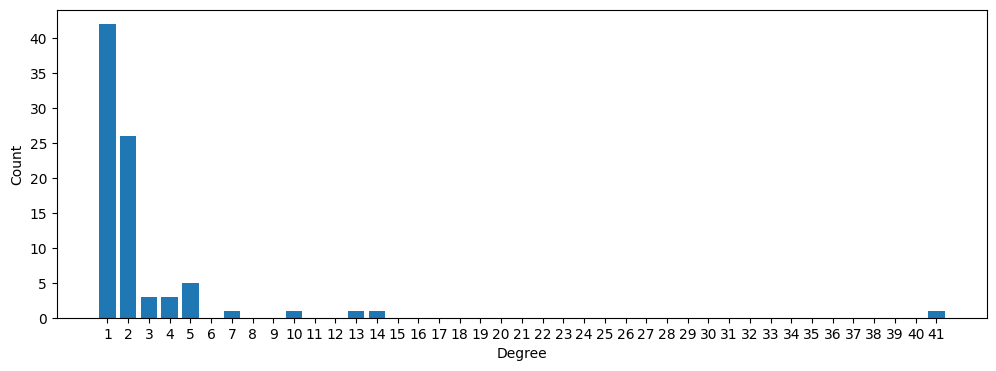

In [538]:
centers, heights = xgi.degree_histogram(H)

plt.figure(figsize=(12, 4))
ax = plt.subplot(111)

ax.bar(centers, heights)
ax.set_ylabel("Count")
ax.set_xlabel("Degree")
ax.set_xticks(np.arange(1, max(centers) + 1, step=1));

Highest degree 2010-2012: Laurent Hébert‐Dufresne
Highest degree 2013-2015: Laurent Hébert‐Dufresne
Highest degree 2016-2018: Laurent Hébert‐Dufresne


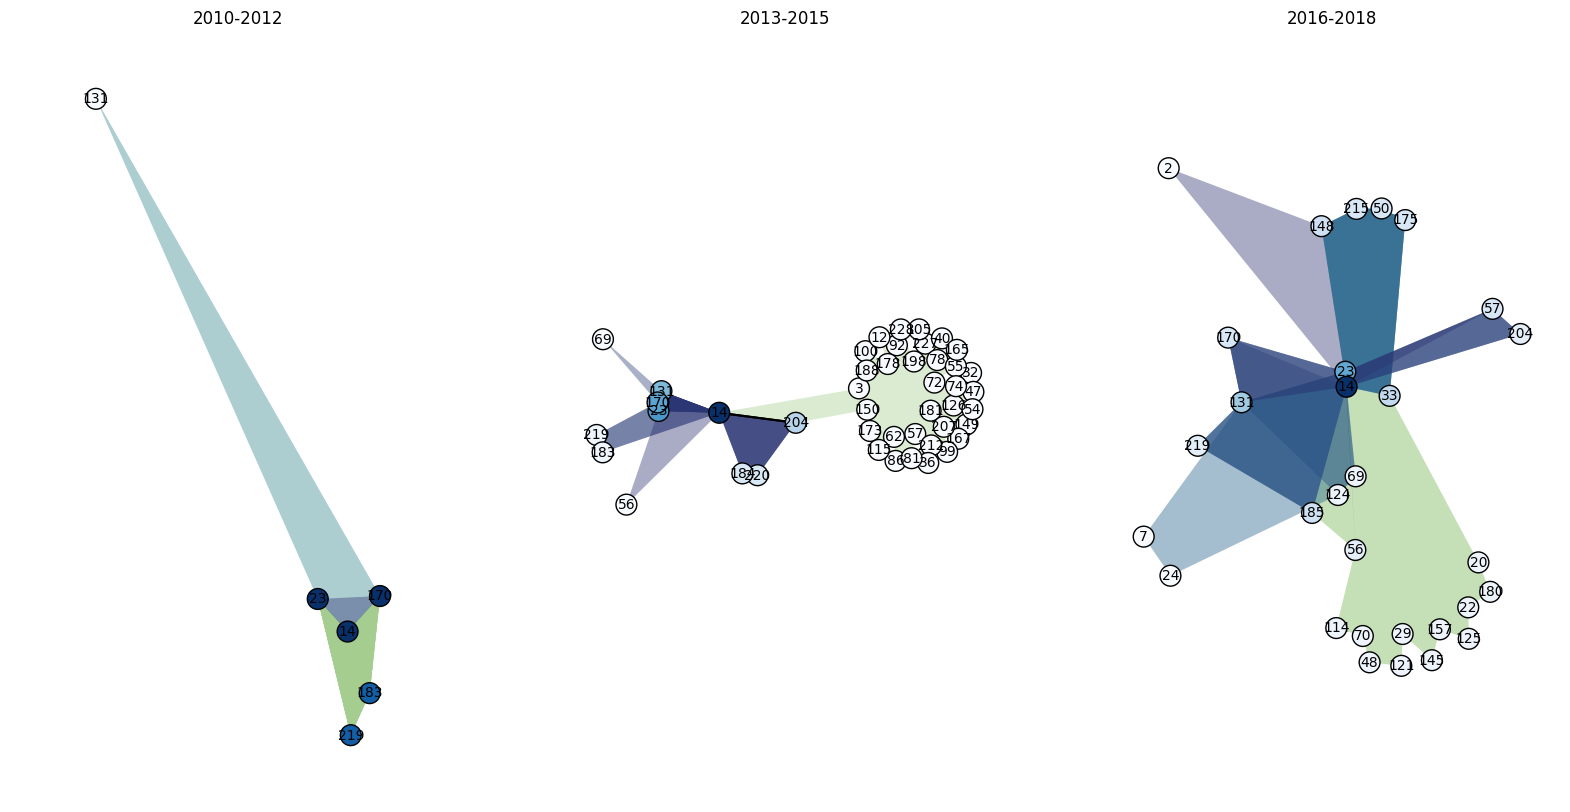

In [222]:
yr_window = 3
tot_yrs = list(range(0, len(PI_fnames)+1, yr_window))
tot_frames = len(tot_yrs)
nb_rows = tot_frames // 3
height_d = { 1:20, 2:15, 3:10 }
fig, axes = plt.subplots(nb_rows, 3, figsize=(20,height_d[yr_window]))

for idx, ax in zip(tot_yrs, axes.flatten()):
    hyperedge_list = []
    for i,fname in enumerate(PI_fnames[idx:(idx+yr_window)]):
        work = read_jsonl(fname)
        if i == 0:
            first_yr=fname.stem.split('_')[-1]
        last_yr=fname.stem.split('_')[-1]
        hyperedge_list += [extract_coauthor(w, names=False) for w in work]
    
        
    H = xgi.Hypergraph(hyperedge_list)
    if len(H.nodes) > 0:
        pos = xgi.barycenter_spring_layout(H, seed=42)  # fix position
        _, collections = xgi.draw(H, ax=ax, pos=pos, node_size=15, node_labels=True, node_fc=H.nodes.degree(), node_fc_cmap="Blues")
        (node_collection, _, _) = collections

        max_key = max(H.nodes.degree().asdict(), key=H.nodes.degree().asdict().get)
        ax.set_title(f"{first_yr}-{last_yr}") if yr_window > 1 else ax.set_title(f"{first_yr}")
        # print(f"{len(hyperedge_list)} papers are shown")
        print(f"Highest degree {first_yr}-{last_yr}: {idx2name[max_key]}") # highest degree node 
